Requirements:
```
Collecting lmfit==0.9.12
Collecting uncertainties>=3.0 (from lmfit==0.9.12)
Collecting scipy>=0.17 (from lmfit==0.9.12)
  Downloading https://files.pythonhosted.org/packages/7f/5f/c48860704092933bf1c4c1574a8de1ffd16bf4fde8bab190d747598844b2/scipy-1.2.1-cp36-cp36m-manylinux1_x86_64.whl (24.8MB)
    100% |████████████████████████████████| 24.8MB 236kB/s eta 0:00:01    68% |██████████████████████          | 17.0MB 41.9MB/s eta 0:00:01
Collecting six>1.10 (from lmfit==0.9.12)
  Downloading https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
Collecting asteval>=0.9.12 (from lmfit==0.9.12)
Collecting numpy>=1.10 (from lmfit==0.9.12)
  Downloading https://files.pythonhosted.org/packages/35/d5/4f8410ac303e690144f0a0603c4b8fd3b986feb2749c435f7cdbb288f17e/numpy-1.16.2-cp36-cp36m-manylinux1_x86_64.whl (17.3MB)
    100% |████████████████████████████████| 17.3MB 247kB/s eta 0:00:01
Installing collected packages: uncertainties, numpy, scipy, six, asteval, lmfit
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  The scripts f2py, f2py3 and f2py3.6 are installed in '/home/jovyan/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Found existing installation: scipy 1.0.0
    Uninstalling scipy-1.0.0:
      Successfully uninstalled scipy-1.0.0
  Found existing installation: lmfit 0.9.12
    Uninstalling lmfit-0.9.12:
      Successfully uninstalled lmfit-0.9.12
Successfully installed asteval-0.9.13 lmfit-0.9.12 numpy-1.16.2 scipy-1.2.1 six-1.12.0 uncertainties-3.0.3
```
also:
```
opencv-python                     4.0.0.21  
```

In [6]:
from lmfit import Minimizer, Parameters, report_fit

In [3]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

## GCA

In [3]:
from operator import itemgetter
import numpy as np

def enforce_bounds(params, LowerBound, UpperBound):
    new_params = []
    for i in np.arange(len(params)):
        currene_param = params[i]
        lb = LowerBound[i]
        ub = UpperBound[i]
        if currene_param<lb:
            currene_param = lb
        elif currene_param>ub:
            currene_param = ub
        new_params.append(currene_param)
    return new_params

def RandomParameters(PopulationSize,OrigialParameters,scale,LowerBound,UpperBound):
    #PopulationSize is the number of randomized sets of parameters this function generates.
    #OriginalParemeters will be a first educated guess and the rest of the
    #parameters will be generated around it.
    #scale is the relative value of the change, scale = 1 means  new parameters
    #will be roughly the same order of magnitude; scale = 0.1 means the new
    #parameters will be roughly 1/10th of the original ones.
    to_return = []
    i = 0
    while i<PopulationSize:
        temp = [(param+np.finfo(float).eps)*(1+scale*(2*np.random.uniform()-1)) for param in OrigialParameters]
        temp = enforce_bounds(temp, LowerBound, UpperBound)
        to_return.append(temp)
        
        i+=1
    return to_return

def GenerationFitness(FitFun,Generation):
    Gi_fit = []
    for i in np.arange(len(Generation)):
        Gi_fit.append(FitFun(Generation[i]))
        if np.isnan(Gi_fit[i]):
            Gi_fit[i] = numpy.NINF
    return Gi_fit

def crossover(Gi_mate_1,Gi_mate_2,CrossPoint):
    Offspring = []
    for parent1, parent2 in zip(Gi_mate_1,Gi_mate_2):
        parent1 = list(parent1)
        parent2 = list(parent2)
        off_1 = parent1[0:CrossPoint]+parent2[CrossPoint:]
        off_2 = parent2[0:CrossPoint]+parent1[CrossPoint:]
        Offspring.append(off_1)
        Offspring.append(off_2)
    return Offspring

def mutate(Offsprings,MutRate,MutMagnitude,Mutation_dampering,lb,ub):
    new_offsprings = []
    decaying_rate = 0.9
    
    # for each each offspring, chek if there will be a mutation on each gene
    for offspring in Offsprings:
        new_off = []
        for gene in offspring:
            if np.random.binomial(n=1,p=decaying_rate) == 1:
                new_gene = (gene+np.finfo(float).eps) * (1+ MutMagnitude*(2*np.random.uniform()-1)) * decaying_rate**Mutation_dampering
            else:
                new_gene = gene
            new_off.append(new_gene)
        new_offsprings.append(enforce_bounds(new_off,lb,ub))
    return new_offsprings


def genetic_algorithm(FitFun, initial_guess, lower_bound, upper_bound, options=None):
    #Custom Genetic Algorithm. Developed by Edwin Juarez on 2016-03-21, ported to python on 2019-03-12

    #Initialize the parameters
    parameters = initial_guess
    chromosome_length = len(parameters)
    fitness = np.NINF

    # fprintf('The initial guess is:');
    # parameters
    fitness = FitFun(initial_guess)

    # Choose parameters:
    
    ## Population Size, N : Depends on the dimensions of the sample space
    PopSize = 1e2

    ## Number of mating individuals must be an even number
    FittestNumber = int(min(PopSize*0.1,10**3*0.05)) # 10 percent of the population will reproduce up to 50 individuals

    ## Number of "Elite" individuals who will remain from Gen[i] to Gen[i+1]
    Elite = int(min(PopSize*0.1,10**3*0.05)) # 10 percent of the population up to 50 individuals

    ## Number of Generations to Simulate: How many iterations to simulate? Presumably the more the better.
    LastGen = 50

    ## Mutation Rates: Probability of each gene (parameter) having a point mutation.
    MutRate = 0.98 # there is a 98 percent chance of a mutation. There is a lot of genetic variation!
    MutMagnitude = 2 # with a mutation the parameter will change up to 100%

    # Crossover Points: Location(s) where the individuals swap genes in producing children (next generation).
    # CrossPoint = 1; # swap (after) the first "chromosome" [parameter]
    CrossPoint = int(np.floor(1+chromosome_length*np.random.uniform())) # Discrete Uniform RV ranging from 1 to chromosome_length (the number of parameters)
    
    # Initialize the G[0] population randomly: Create a set of N solutions randomly
    # Gi = RandomParameters(PopSize,parameters);
    Gi = RandomParameters(PopSize,parameters,1,lower_bound,upper_bound);
#     vanguardia=Gi(1:4,:);
#     prev_vanguardia = Gi(1,:);
    # Running the main loop now
    i=0
    print('Runing the custom genetic algorithm')
#     print("The first generation takes the longest")
    while i<LastGen:
#         print(f"Generation {i}")
        # Calculate fitness for population
        Gi_fit = GenerationFitness(FitFun,Gi)

        ## Select mates to create children for the G1 (N+1) population
        ## Mate selection: Individuals ranked proportional to their fitness

        ###Order them from the most fit to the least fit
        temp = []
        for params, fitness in zip(Gi, Gi_fit):
            temp2 = params.copy()
            temp2.append(fitness)
            temp.append(temp2)
        temp = sorted(temp, key=itemgetter(len(temp[0])-1), reverse=True)
        ###Consider only the fittest individuals
        Gi_fittest = temp[0:FittestNumber]
        # Drop the fitness
        for x in Gi_fittest:
            del x[len(x)-1]

        ###Randomly assign mates
        Gi_mate = np.random.permutation(Gi_fittest) # permutate all individuals
        Gi_mate_1 = Gi_mate[0:int(FittestNumber/2)] # split the population in two
        Gi_mate_2 = Gi_mate[int(FittestNumber/2):]

        ### Mate: Genes are exchanged prescribed by cross-over points
        Offsprings = crossover(Gi_mate_1,Gi_mate_2,CrossPoint)

        ### Introduce point mutations: 
        Offsprings = mutate(Offsprings,MutRate,MutMagnitude,i,lower_bound,upper_bound)

        ### Clone the Elite members and mutate the clones
        Clones = mutate(Gi_fittest[0:Elite],MutRate,MutMagnitude,1,lower_bound,upper_bound)

        ### "Elite" fittest individuals mate with the next generation,
        ### a mutated clone of some them also carries on.

        ### on each generation a number of random individuals show up equal to the
        ### number of Elite individuals
        Gi = Gi_fittest[0:Elite]+Clones+Offsprings+RandomParameters(Elite,parameters,1,lower_bound,upper_bound)
        i += 1
    print(f'Done!, fittest individual was {Gi_fittest[0]} with fitness {FitFun(Gi_fittest[0])}')
    return Gi_fittest[0]

##  Create Cells Mask

Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.
A value of 0 means it deos not belong the mask and it is rendered as black.


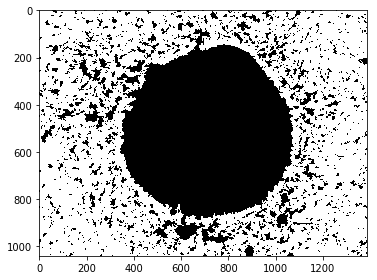

In [7]:
# Mostly from here: https://www.learnopencv.com/filling-holes-in-an-image-using-opencv-python-c/
%matplotlib inline
import cv2
import numpy as np
from skimage import draw
from skimage import io

 
# Read image
im_in = cv2.imread("analyses/MDA231_stopper_1_c3.tif", cv2.IMREAD_GRAYSCALE);
 
# Threshold.
# Set values equal to or above 20 to 0.
# Set values below 20 to 255.
 
th, im_th = cv2.threshold(im_in, 20, 255, cv2.THRESH_BINARY_INV);
 
# Copy the thresholded image.
im_floodfill = im_th.copy()
 
# Mask used to flood filling.
# Notice the size needs to be 2 pixels than the image.
h, w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
 
# Floodfill from point (0, 0)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
 
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
 
# Combine the two images to get the foreground.
im_out = im_th | im_floodfill_inv
io.imsave(fname='temp_output.png', arr=im_out)

# im_out_inv = cv2.bitwise_not(im_out)


# dilate the mask:
k_size = 2
k_half = k_size/2
kernel = np.ones((k_size,k_size),np.uint8)
coords = draw.circle(k_half, k_half, k_half, shape=im_th.shape)
kernel[coords] = 1 
erosion = cv2.erode(im_out,kernel,iterations = 1)
dilation = cv2.dilate(cv2.bitwise_not(erosion),kernel,iterations = 1)
# cells_mask = cv2.bitwise_not(dilation)
cells_mask = dilation/255


io.imshow(cells_mask)
print("Note that a value of ~1 means that pixel belongs to the mask and it is rendered as white.")
print("A value of 0 means it deos not belong the mask and it is rendered as black.")
# io.imsave(fname='mask.png', arr=dilation)

## cost functions

### optimize

In [8]:
from skimage import io, color, measure, draw, img_as_bool
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [9]:
filename = 'analyses/MDA231_stopper_1_c3.tif'
image = io.imread(filename,as_grey=True)
im2 = image>0.2
im2 = im2.astype(int)

/opt/conda/envs/python3.6/lib/python3.6/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')


In [10]:
maxy, maxx = image.shape
minx, miny = (0,0)
maxr = min(maxx,maxy)/2

In [11]:
x0 = im2.shape[1]/2
y0 = im2.shape[0]/2
r0 = im2.shape[1]/3

In [12]:
image_gray = im2.copy()


In [2]:
@genepattern.build_ui
def cost(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params[0]
    y0 = params[1]
    r0 = params[2]
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return -score

def cost_obj(params):
    # normalize axis:
    image = im2.copy()
    maxy, maxx = image.shape
    maxr = min(maxx,maxy)/2
    area = maxy*maxx
    
    
    x0= params['x']
    y0 = params['y']
    r0 = params['r']
    
    coords = draw.circle(y0, x0, r0, shape=image.shape)
    template = np.zeros_like(image) #set all values to be zero
    template[coords] = 1
    
    penalty = 10*np.sum(template & image)/area # penalizing for circles that cover cells
    
    # values outside of the box should be penalized too
    if (x0+r0>maxx):
        penalty = penalty + 2*np.pi*r0*r0/area * (x0+r0-maxx)/maxx
    if (y0+r0>maxy):
        penalty = penalty + 2*np.pi*r0*r0/area * (y0+r0-maxy)/maxy
    if (x0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-x0)/maxx
    if (y0-r0 <0):
        penalty = penalty + 2*np.pi*r0*r0/area * (r0-y0)/maxy
    
    good_score = 2*np.pi*r0*r0/area
    score = good_score-penalty
    
    return -score

UIBuilder(function_import='cost', name='cost', params=[{'name': 'params', 'label': 'params', 'optional': False…

In [11]:
import matplotlib.pyplot as plt

In [13]:
from lmfit import Minimizer, Parameters, report_fit

In [49]:
# create a set of Parameters
params = Parameters()
params.add('x', value=x0, min=0, max=maxx)
params.add('y', value=y0, min=0, max=maxy)
params.add('r', value=r0/3, min=0, max=maxr)

In [50]:
%%time
# do fit, here with leastsq model
minner = Minimizer(cost_obj, params)
result = minner.minimize(method='brute')
report_fit(result)

[[Fit Statistics]]
    # fitting method   = brute
    # function evals   = 8000
    # data points      = 1
    # variables        = 3
    chi-square         = 0.21843879
    reduced chi-square = 0.21843879
    Akaike info crit   = 4.47875057
    Bayesian info crit = -1.52124943
[[Variables]]
    x:  730.526316 (init = 694)
    y:  547.368421 (init = 520)
    r:  355.789474 (init = 154.2222)
CPU times: user 1min 48s, sys: 4.06 s, total: 1min 52s
Wall time: 1min 52s


[730.5263157894738, 547.3684210526316, 355.7894736842105]
############
Method "None""	objective=-0.4673743593172863
############


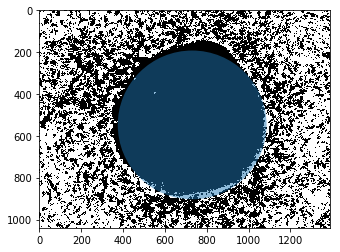

In [51]:
x_opt = result.params['x'].value
y_opt = result.params['y'].value
r_opt = result.params['r'].value
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(im2, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()

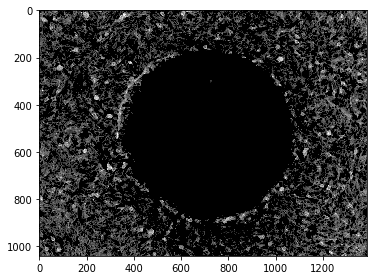

In [60]:
filename = 'analyses/MDA231_stopper_2_c3.tif'
image = io.imread(filename,as_grey=True)
io.imshow(image)

[730.5263157894738, 547.3684210526316, 355.7894736842105]
############
Method "None""	objective=-0.4673743593172863
############


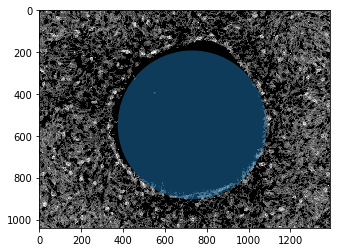

In [58]:
x_opt = result.params['x'].value
y_opt = result.params['y'].value
r_opt = result.params['r'].value
print([x_opt,y_opt,r_opt])
f, ax = plt.subplots()
circle = plt.Circle((x_opt, y_opt), r_opt, alpha = 0.5)
ax.imshow(image, cmap='gray', interpolation='nearest')
ax.add_artist(circle)
print('############')
print(f'Method "{method}""\tobjective={cost([x_opt,y_opt,r_opt])}')
print('############')
plt.show()